In [314]:
import config
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import FixedLocator
from sqlalchemy import create_engine

pd.set_option("display.precision", 2)

In [315]:
#import config dataW
mysql = config.mysql

#connect to database
connection_string = (
    f"postgresql://{mysql['user']}:{mysql['password']}@"
    f"{mysql['host']}:{mysql['port']}/{mysql['dbname']}"
)

engine = create_engine(connection_string)

# To create a connection, you can use
conn = engine.connect()
    

In [316]:
#list of provinces in  Poland
provinces = [
    "dolnoslaskie"
    ,"kujawsko_pomorskie"
    ,"lubelskie"
    ,"lubuskie"
    ,"lodzkie"
    ,"malopolskie"
    ,"mazowieckie"
    ,"opolskie"
    ,"podkarpackie"
    ,"podlaskie"
    ,"pomorskie"
    ,"slaskie"
    ,"swietokrzyskie"
    ,"warminsko_mazurskie"
    ,"wielkopolskie"
    ,"zachodniopomorskie"
    ]

In [317]:
#dataframe to province total area renewable solar and wind
solar_area_append_total = {'Province': [], 'solar_area': []}
wind_area_append_total = {'Province': [], 'wind_area': []}

# Import data from database
for province in provinces:
    #select tables
    table_name_solar = f"solar_radiation_photovoltaic_area_{province}"
    table_name_wind = f"wind_speed_area_{province}"
  
    #select data in tables
    query_solar = (f"SELECT SUM(area) as solar_total_area "
                   f"FROM {table_name_solar}")
    query_wind = (f"SELECT SUM(area) as wind_total_area "
                  f"FROM {table_name_wind}")
    #result to pandas
    solar_result = pd.read_sql(query_solar, conn)
    wind_result = pd.read_sql(query_wind, conn)
    
    #check select data 
    if not solar_result.empty and solar_result['solar_total_area'][0] is not None:
        solar_area = solar_result['solar_total_area'][0]
    else:
        solar_area = 0

    if not wind_result.empty and wind_result['wind_total_area'][0] is not None:
        wind_area = wind_result['wind_total_area'][0]
    else:
        wind_area = 0
    
    #append data to column and change m^2 to km^2
    solar_area_append_total['Province'].append(province)
    solar_area_append_total['solar_area'].append(round(solar_area * 1e-6,2))
    
    
    wind_area_append_total['Province'].append(province)
    wind_area_append_total['wind_area'].append(round(wind_area * 1e-6,2))

    

df_solar = pd.DataFrame(solar_area_append_total)
df_wind = pd.DataFrame(wind_area_append_total)
df_solar


,Province,solar_area
0,dolnoslaskie,480.64
1,kujawsko_pomorskie,262.50
2,lubelskie,594.29
3,lubuskie,326.41
4,lodzkie,485.20
5,malopolskie,441.87
6,mazowieckie,1344.64
7,opolskie,90.20
8,podkarpackie,568.48
9,podlaskie,962.12


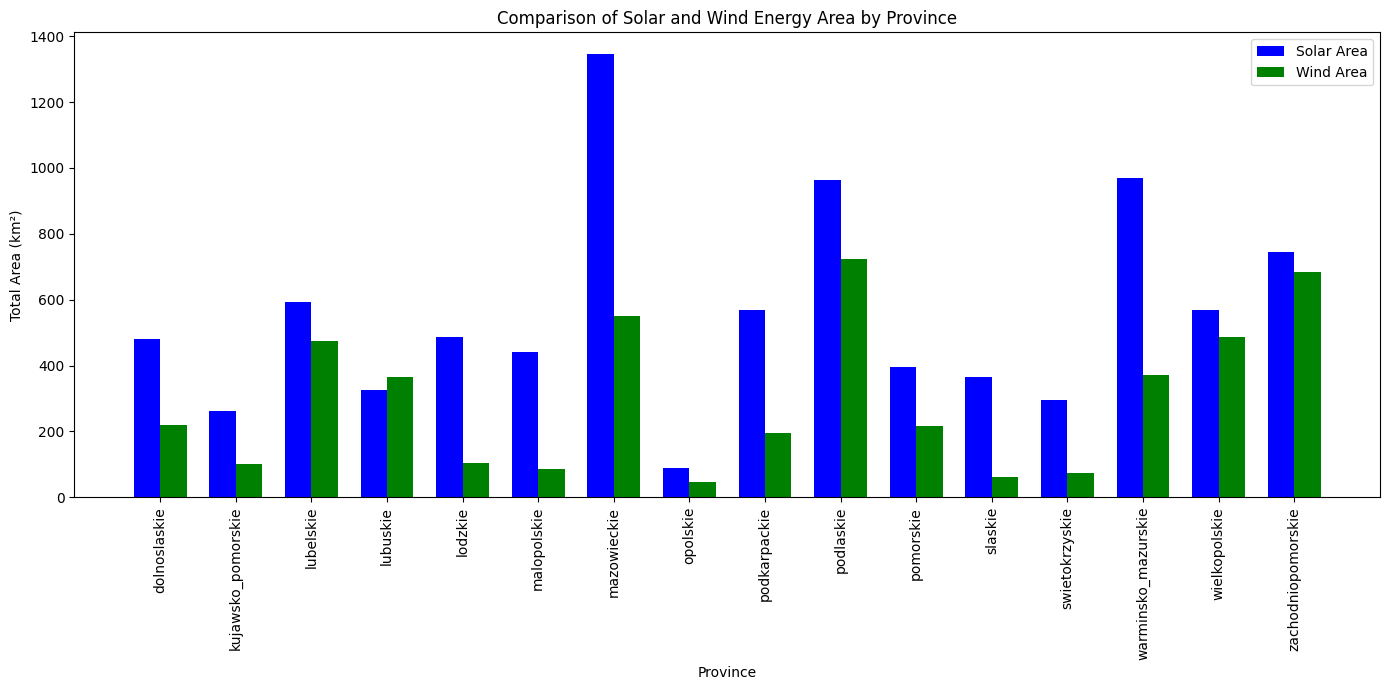

In [318]:
# Generowanie wykresu słupkowego
plt.figure(figsize=(14, 7))
width = 0.35  # szerokość słupków

# Pozycje słupków dla każdego województwa
ind = range(len(df_solar['Province']))

# Tworzenie słupków dla energii słonecznej i wiatrowej
plt.bar(ind, df_solar['solar_area'], width=width, label='Solar Area', color='blue')
plt.bar([i + width for i in ind], df_wind['wind_area'], width=width, label='Wind Area', color='green')

# Dodanie opisów i tytułu
plt.xlabel('Province')
plt.ylabel('Total Area (km²)')
plt.title('Comparison of Solar and Wind Energy Area by Province')
plt.xticks([i + width / 2 for i in ind], df_solar['Province'], rotation=90)
plt.legend()

# Wyświetlenie wykresu
plt.tight_layout()
plt.show()

In [319]:
#photovoltaic standard panels parametrs [km^2]
height_panel = 1.016
width_panel = 1.686
power_output = 350 #[W]
power_output_m2 = power_output / (height_panel * width_panel)

#panel efficiency by producent 25*C, 1000 [Wm^2]/ power efficency ~20%
efficiency = (power_output / (height_panel*width_panel  * 1000))
efficiency

#power_per_m2 = efficiency_producent_m2 * irradiance


0.2043227692623831

In [320]:
#create effective area. We can't use whole area. In this case we use 80% area to solar panels and 20% for equipment and maintenance access
#parametrs 
solar_maintenance_access = 0.2
effective_solar_panel_area = 1 - solar_maintenance_access

#calculate the effective area
df_solar['solar_effective_area'] = (df_solar['solar_area'] * effective_solar_panel_area)
df_solar

,Province,solar_area,solar_effective_area
0,dolnoslaskie,480.64,384.51
1,kujawsko_pomorskie,262.50,210.00
2,lubelskie,594.29,475.43
3,lubuskie,326.41,261.13
4,lodzkie,485.20,388.16
5,malopolskie,441.87,353.50
6,mazowieckie,1344.64,1075.71
7,opolskie,90.20,72.16
8,podkarpackie,568.48,454.78
9,podlaskie,962.12,769.70


In [321]:
#select tables
months = {
    "january" : 31
    , "february" : 28
    , "march" : 31
    , "april" : 30
    ,"may" : 31
    , "june" : 30
    , "july" : 31
    , "august" : 31
    ,"september" : 30
    , "october" : 31
    , "november" : 30
    , "december" : 31
}

#solar radiation by province and each month
solar_radiation = pd.DataFrame(index=provinces, columns=months.keys())

for province in provinces:
    for month in months:
        table_name_solar = f"solar_radiation_photovoltaic_area_{province}"
        # select data in tables
        #sum of multipe area in m^2 * amount of solar radiation in month [kW] * effective area (80%) * efficency 
        query = f"SELECT SUM(area * {month} * {effective_solar_panel_area} * {efficiency}) as total FROM {table_name_solar}"

        # result to pandas
        result_df = pd.read_sql(query, conn)
        monthly_solar_energy = result_df.iloc[0]['total'] if not result_df.empty else 0
        #solar panel and change kW to  tW
        solar_radiation.at[province, month] = round(monthly_solar_energy * 1e-9,2)
        
#rename index        
solar_radiation.reset_index(inplace=True)
solar_radiation.rename(columns={'index': 'Province'}, inplace=True)

#merge df_solar and solar_radiation
df_solar = df_solar.merge(solar_radiation, left_on='Province', right_on='Province')
df_solar

,Province,solar_area,solar_effective_area,january,february,march,april,may,june,july,august,september,october,november,december
0,dolnoslaskie,480.64,384.51,3.01,5.73,9.97,14.44,17.49,19.29,18.58,15.57,11.07,6.65,3.5,2.29
1,kujawsko_pomorskie,262.50,210.00,1.25,2.64,5.03,7.72,9.75,10.69,10.06,8.27,5.7,3.22,1.5,0.9
2,lubelskie,594.29,475.43,3.46,6.79,12.12,17.92,22.18,24.29,23.51,19.63,13.73,8.07,4.01,2.57
3,lubuskie,326.41,261.13,1.68,3.39,6.31,9.58,11.98,13.19,12.46,10.31,7.22,4.17,2.05,1.25
4,lodzkie,485.20,388.16,2.74,5.41,9.74,14.52,17.96,19.71,18.88,15.71,11.03,6.47,3.23,2.05
5,malopolskie,441.87,353.50,3.16,5.76,9.61,13.46,15.98,17.57,17.3,14.65,10.5,6.5,3.61,2.47
6,mazowieckie,1344.64,1075.71,6.83,14.09,26.3,39.83,50.04,54.74,52.21,43.09,29.81,17.01,8.08,4.95
7,opolskie,90.20,72.16,0.57,1.07,1.86,2.72,3.31,3.65,3.53,2.96,2.1,1.26,0.66,0.43
8,podkarpackie,568.48,454.78,3.77,7.02,12.01,17.19,20.86,22.94,22.58,19.1,13.54,8.2,4.37,2.92
9,podlaskie,962.12,769.70,4.48,9.61,18.43,28.11,35.63,38.82,36.88,30.22,20.61,11.49,5.25,3.15


In [322]:
#wind production

In [323]:
df_wind

,Province,wind_area
0,dolnoslaskie,220.40
1,kujawsko_pomorskie,100.90
2,lubelskie,473.40
3,lubuskie,366.51
4,lodzkie,104.86
5,malopolskie,86.31
6,mazowieckie,551.29
7,opolskie,47.03
8,podkarpackie,195.24
9,podlaskie,722.85


In [324]:
#functional assumption 3 wind turbine for km^2
turbine_number_for_area = 3
df_wind['turbines_number'] = df_wind['wind_area'] * turbine_number_for_area
df_wind['turbines_number'] = df_wind['turbines_number'].astype(int)
#parametrs for wind turbin Vestas V100

#minimum wind speed [m/s]
minimum_wind_speed = 3

#maximum wind speed [m/s]
maximum_wind_speed = 22

#energy generate for 1 hour when wind speed is 22 [mW]
maximum_power_generate = 2 

#power_generate difference by wind speed


df_wind

,Province,wind_area,turbines_number
0,dolnoslaskie,220.40,661
1,kujawsko_pomorskie,100.90,302
2,lubelskie,473.40,1420
3,lubuskie,366.51,1099
4,lodzkie,104.86,314
5,malopolskie,86.31,258
6,mazowieckie,551.29,1653
7,opolskie,47.03,141
8,podkarpackie,195.24,585
9,podlaskie,722.85,2168


In [325]:
wind_energy = pd.DataFrame(index=provinces, columns=months.keys())
for province in provinces:
    for month,days in months.items():
        table_name_wind = f"wind_speed_area_{province}"
        # select data in tables
        ##energy generate for 1 month [mW]
        query = (f"SELECT SUM(CASE "
         f"WHEN {month} > {minimum_wind_speed} THEN ((({month} * 24 * {days}) / {maximum_wind_speed}) * {maximum_power_generate})"
         f"ELSE 0 "
         f"END)  as total "
         f"FROM wind_speed_area_{province}")
# SELECT
# CASE
# WHEN january > 3 THEN 24 * 31
# ELSE 0
# END AS selected_value
# FROM wind_speed_area_dolnoslaskie;
        # result to pandas
        result_df = pd.read_sql(query, conn)
        monthly_wind_speed = result_df.iloc[0]['total'] if not result_df.empty else 0
        
        #change mW to tW
        monthly_wind_speed = round(monthly_wind_speed * 1e-6, 2)
        wind_energy.at[province, month] = monthly_wind_speed
        
#rename index        
wind_energy.reset_index(inplace=True)
wind_energy.rename(columns={'index': 'Province'}, inplace=True)

#merge df_solar and solar_radiation
df_wind = df_wind.merge(wind_energy, left_on='Province', right_on='Province')

df_wind

,Province,wind_area,turbines_number,january,february,march,april,may,june,july,august,september,october,november,december
0,dolnoslaskie,220.40,661,0.45,0.4,0.42,0.12,0.0,0.0,0.0,0.0,0.01,0.26,0.33,0.45
1,kujawsko_pomorskie,100.90,302,0.12,0.1,0.11,0.1,0.07,0.06,0.01,0.0,0.1,0.11,0.1,0.11
2,lubelskie,473.40,1420,0.53,0.48,0.53,0.16,0.02,0.0,0.0,0.0,0.04,0.48,0.51,0.53
3,lubuskie,366.51,1099,0.42,0.38,0.42,0.01,0.0,0.0,0.0,0.0,0.0,0.39,0.41,0.42
4,lodzkie,104.86,314,0.21,0.17,0.19,0.18,0.1,0.0,0.0,0.0,0.16,0.19,0.18,0.19
5,malopolskie,86.31,258,0.1,0.09,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.03,0.04,0.07
6,mazowieckie,551.29,1653,0.74,0.66,0.73,0.23,0.07,0.0,0.0,0.0,0.18,0.69,0.71,0.73
7,opolskie,47.03,141,0.13,0.11,0.12,0.05,0.01,0.0,0.0,0.0,0.01,0.08,0.1,0.13
8,podkarpackie,195.24,585,0.37,0.33,0.35,0.03,0.0,0.0,0.0,0.0,0.0,0.27,0.36,0.38
9,podlaskie,722.85,2168,0.34,0.31,0.34,0.15,0.01,0.0,0.0,0.0,0.11,0.34,0.33,0.34


In [326]:
#zuzycie energii w polsce roczne
#źródło: https://stat.gov.pl/obszary-tematyczne/srodowisko-energia/energia/energia-2023,1,11.html
# [tW]
averange_year_consumption = 180
averange_month_consumption = 180 / 12

In [327]:
#przedstawienie produckji prądu na hipotetycznych danych surowych

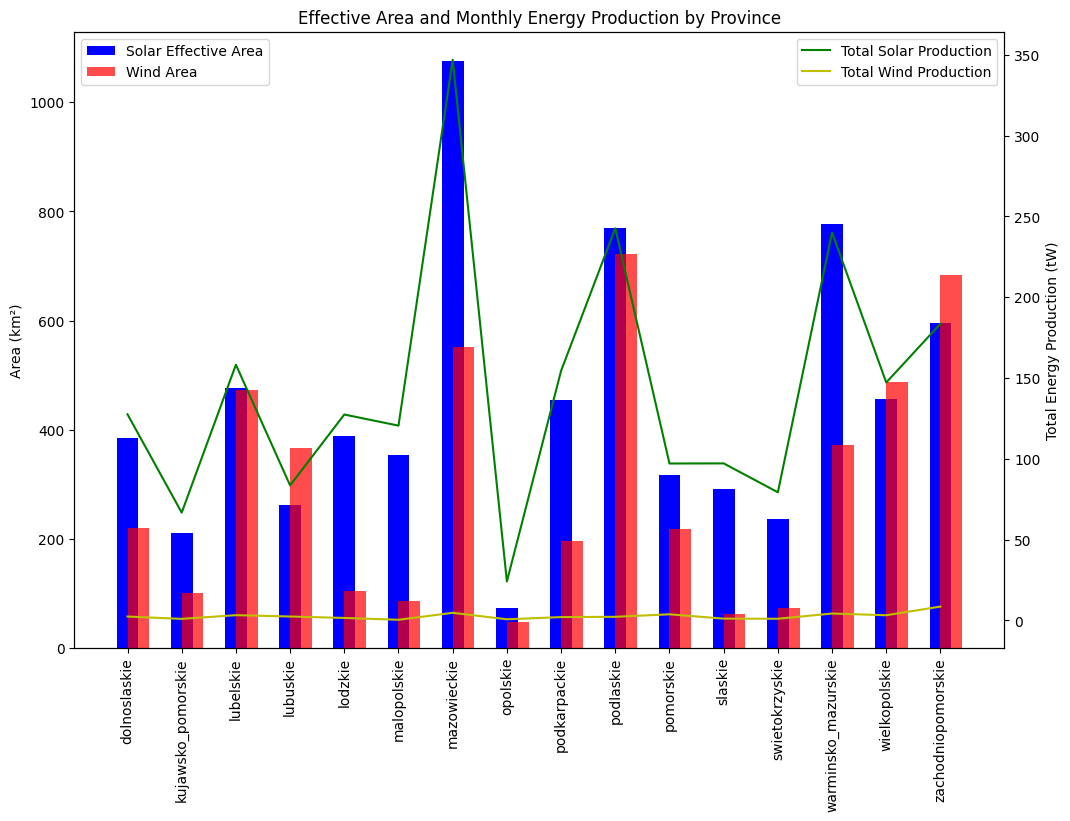

In [328]:
# Wczytanie danych
data_solar = df_solar 
data_wind = df_wind   

# Łączenie danych na podstawie nazwy prowincji
data_combined = pd.merge(data_solar, data_wind, on='Province', suffixes=('_solar', '_wind'))

# Sumowanie danych miesięcznych dla energii słonecznej i wiatrowej
monthly_solar = data_combined.loc[:, 'january_solar':'december_solar'].sum(axis=1)
monthly_wind = data_combined.loc[:, 'january_wind':'december_wind'].sum(axis=1)

# Tworzenie wykresu
fig, ax1 = plt.subplots(figsize=(12, 8))

# Wykres słupkowy dla powierzchni
ax1.bar(data_combined['Province'], data_combined['solar_effective_area'], color='b', label='Solar Effective Area', width=0.4, align='center')
ax1.bar(data_combined['Province'], data_combined['wind_area'], color='r', alpha=0.7, label='Wind Area', width=0.4, align='edge')
ax1.set_ylabel('Area (km²)')
ax1.set_title('Effective Area and Monthly Energy Production by Province')
tick_locations = range(len(data_combined['Province']))  # Positions for each tick
ax1.xaxis.set_major_locator(FixedLocator(tick_locations))
ax1.set_xticklabels(data_combined['Province'],rotation = 90)
ax1.legend(loc='upper left')

# Wykres liniowy dla produkcji energii
ax2 = ax1.twinx()
ax2.plot(data_combined['Province'], monthly_solar, 'g-', label='Total Solar Production')
ax2.plot(data_combined['Province'], monthly_wind, 'y-', label='Total Wind Production')
ax2.set_ylabel('Total Energy Production (tW)')
ax2.legend(loc='upper right')

plt.show()


In [329]:
#zuzycie energii w polsce roczne
#źródło: https://stat.gov.pl/obszary-tematyczne/srodowisko-energia/energia/energia-2023,1,11.html

In [330]:
# [tW]
averange_year_consumption = 180
averange_month_consumption = 180/12

In [331]:
df_solar_bulding_cost = pd.DataFrame()
for province in provinces:
    table_name = f"solar_radiation_photovoltaic_area_{province}"
    # select data in tables
    #sum of multipe area in m^2 * amount of solar radiation in month [kW] * effective area (80%) * efficency change to [mW]
        #koszt instalacji fotowoltaicznych
    #żródło https://ieo.pl/pl/aktualnosci/1538-rynek-fotowoltaiki-w-polsce-2021
    # Dla małych instalacji 50-500 kWp - 3,51 mln zł / MWp
    # Dla farm fotowoltaicznych mniejszych niż 1 MWp - 2,63 mln zł / MWp
    # Dla farm fotowoltaicznych większych niż 1 MWp - 2,05 mln zł / MWp KOSZTY W MLN 
    #Operacyjne koszty instalacji fotowoltaicznej o mocy 1 MW wynoszą mniej więcej 70 000 zł
    query = (
    f"SELECT "
    f"'{province}' AS Province, " 
    f"sum(area * {effective_solar_panel_area} * {efficiency} * 1e-3) AS solar_energy_production_mWp, "
    f"sum(CASE "
    f"    WHEN area * {effective_solar_panel_area} * {efficiency} * 1e-3 < 0.5 THEN 3.51 * area * {effective_solar_panel_area} * {efficiency} * 1e-3 "
    f"    WHEN area * {effective_solar_panel_area} * {efficiency} * 1e-3 <= 1 THEN 2.63 * area * {effective_solar_panel_area} * {efficiency} * 1e-3 "
    f"    WHEN area * {effective_solar_panel_area} * {efficiency} * 1e-3 > 1 THEN 2.05 * area * {effective_solar_panel_area} * {efficiency} * 1e-3 "
    f"    ELSE 0 "
    f"END) AS solar_building_cost_mln_zl "
    f"FROM {table_name}"
    )
    
    # result to pandas
    result_df = pd.read_sql(query, conn)
    df_solar_bulding_cost = pd.concat([df_solar_bulding_cost, result_df], ignore_index=True)

df_solar_bulding_cost


,province,solar_energy_production_mwp,solar_building_cost_mln_zl
0,dolnoslaskie,78563.88,161055.95
1,kujawsko_pomorskie,42907.01,87959.37
2,lubelskie,97142.21,199141.54
3,lubuskie,53353.69,109375.06
4,lodzkie,79310.27,162586.05
5,malopolskie,72227.52,148066.41
6,mazowieckie,219792.86,450575.36
7,opolskie,14743.27,30223.70
8,podkarpackie,92922.82,190491.78
9,podlaskie,157266.51,322396.34


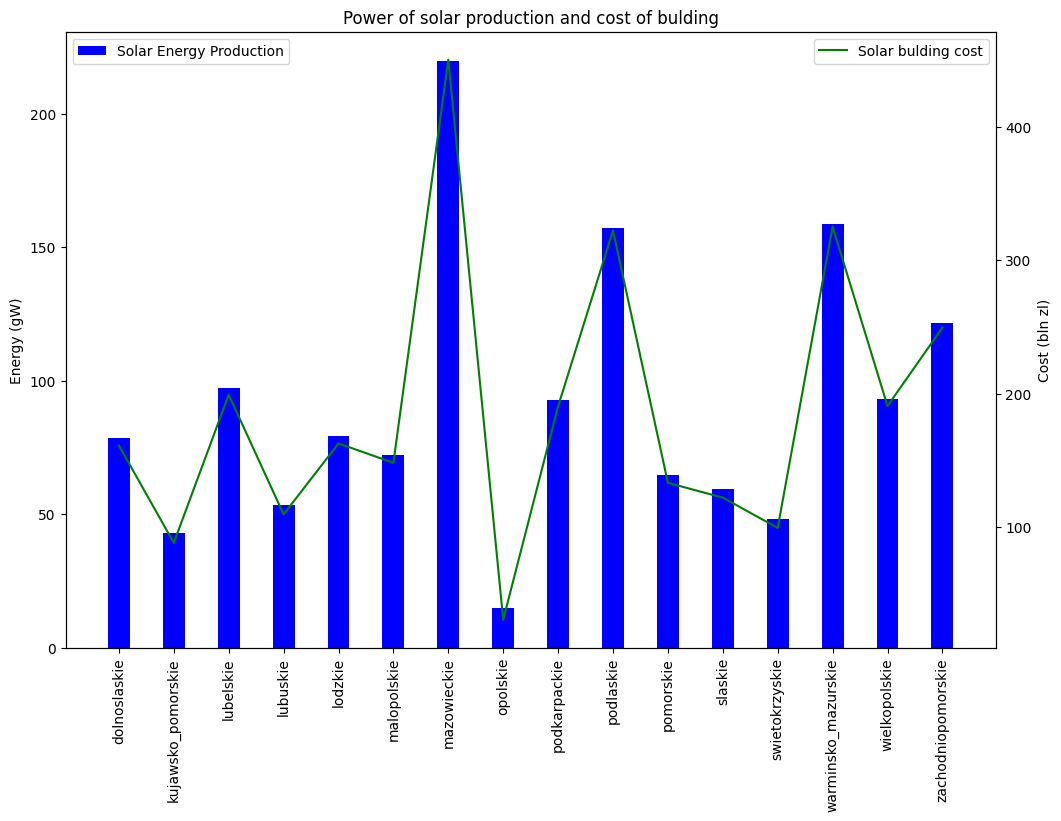

In [340]:
# Tworzenie wykresu
fig, ax1 = plt.subplots(figsize=(12, 8))

# Wykres słupkowy dla powierzchni
ax1.bar(df_solar_bulding_cost['province'], df_solar_bulding_cost['solar_energy_production_mwp']*1e-3, color='b', label='Solar Energy Production', width=0.4, align='center')
ax1.set_ylabel('Energy (gW)')
ax1.set_title('Power of solar production and cost of bulding')
tick_locations = range(len(df_solar_bulding_cost['province']))  # Positions for each tick
ax1.xaxis.set_major_locator(FixedLocator(tick_locations))
ax1.set_xticklabels(df_solar_bulding_cost['province'],rotation = 90)
ax1.legend(loc='upper left')

# Wykres liniowy dla produkcji energii
ax2 = ax1.twinx()
#change mln to mld
ax2.plot(df_solar_bulding_cost['province'], df_solar_bulding_cost['solar_building_cost_mln_zl']*1e-3, 'g-', label='Solar bulding cost')
ax2.set_ylabel('Cost (bln zl)')
ax2.legend(loc='upper right')

plt.show()

In [331]:
#analiza 